In [1]:
import os
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Set paths
base_dir = 'handwriting_data'
normal_dir = os.path.join(base_dir, 'normal')
corrected_dir = os.path.join(base_dir, 'corrected')
reversal_dir = os.path.join(base_dir, 'reversal')

In [3]:
# Load and preprocess images
def load_images_from_folder(folder, label):
    images = []
    labels = []
    valid_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.gif')
    for root, dirs, files in os.walk(folder):
        for filename in files:
            if filename.lower().endswith(valid_extensions):
                try:
                    img_path = os.path.join(root, filename)
                    img = Image.open(img_path).convert('L')  # Convert to grayscale
                    img = img.resize((32, 32))
                    img = np.array(img)
                    images.append(img)
                    labels.append(label)
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")
    return images, labels

In [4]:
# Data augmentation functions
def augment_image(image):
    augmented_images = []
    
    # Horizontal flip
    flipped_image = ImageOps.mirror(image)
    augmented_images.append(flipped_image)
    
    # Rotation
    for angle in [20, -20]:
        rotated_image = image.rotate(angle)
        augmented_images.append(rotated_image)
    
    # Foreground-background interchange
    inverted_image = ImageOps.invert(image)
    augmented_images.append(inverted_image)
    
    # Noise injection
    for intensity in [1.5, 2.0]:
        noisy_image = np.array(image) + intensity * np.random.randn(*image.size)
        noisy_image = Image.fromarray(np.clip(noisy_image, 0, 255).astype('uint8'))
        augmented_images.append(noisy_image)
    
    return augmented_images


In [5]:
# Load images from each folder and their respective labels
normal_images, normal_labels = load_images_from_folder(normal_dir, 0)
corrected_images, corrected_labels = load_images_from_folder(corrected_dir, 2)
reversal_images, reversal_labels = load_images_from_folder(reversal_dir, 1)

In [6]:
# Apply augmentation to normal images to create reversal images
augmented_reversal_images = []
for img in normal_images:
    pil_img = Image.fromarray(img)
    augmented_images = augment_image(pil_img)
    for augmented_img in augmented_images:
        augmented_reversal_images.append(np.array(augmented_img))

In [7]:
# Combine the images and labels into a single dataset
all_images = normal_images + corrected_images + reversal_images + augmented_reversal_images
all_labels = normal_labels + corrected_labels + reversal_labels + [1] * len(augmented_reversal_images)


In [8]:
# Convert to numpy arrays
images = np.array(all_images)
labels = np.array(all_labels)

In [9]:
# Print the number of images after augmentation
print(f'Number of images after augmentation: {len(images)}')

Number of images after augmentation: 174065


In [10]:
# Normalize the images
images = images / 255.0

In [11]:
# Reshape for the model input
images = images.reshape(-1, 32, 32, 1)

In [12]:
# One-hot encode the labels
labels = to_categorical(labels, num_classes=3)

In [13]:
# Split the dataset
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [14]:
# Data augmentation for training
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

In [15]:
# Build the CNN model (modified LeNet-5)
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='swish', input_shape=(32, 32, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Dropout(0.25),
    
    Conv2D(64, kernel_size=(3, 3), activation='swish'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Dropout(0.25),
    
    Conv2D(128, kernel_size=(3, 3), activation='swish'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Dropout(0.25),
    
    Flatten(),
    Dense(128, activation='swish'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(3, activation='softmax')
])

C:\Users\ALIKO\Desktop\hand-writing-model\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    epochs=50,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

Epoch 1/50


C:\Users\ALIKO\Desktop\hand-writing-model\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3808/3808 ━━━━━━━━━━━━━━━━━━━━ 172s 43ms/step - accuracy: 0.7158 - loss: 0.7710 - val_accuracy: 0.7871 - val_loss: 0.7252
Epoch 2/50
3808/3808 ━━━━━━━━━━━━━━━━━━━━ 144s 38ms/step - accuracy: 0.8123 - loss: 0.5120 - val_accuracy: 0.7999 - val_loss: 0.8560
Epoch 3/50
3808/3808 ━━━━━━━━━━━━━━━━━━━━ 145s 38ms/step - accuracy: 0.8232 - loss: 0.4759 - val_accuracy: 0.7935 - val_loss: 1.0923
Epoch 4/50
3808/3808 ━━━━━━━━━━━━━━━━━━━━ 149s 39ms/step - accuracy: 0.8268 - loss: 0.4505 - val_accuracy: 0.8304 - val_loss: 0.4705
Epoch 5/50
3808/3808 ━━━━━━━━━━━━━━━━━━━━ 128s 34ms/step - accuracy: 0.8332 - loss: 0.4038 - val_accuracy: 0.8517 - val_loss: 0.3485
Epoch 6/50
3808/3808 ━━━━━━━━━━━━━━━━━━━━ 150s 39ms/step - accuracy: 0.8379 - loss: 0.3795 - val_accuracy: 0.8008 - val_loss: 0.8089
Epoch 7/50
3808/3808 ━━━━━━━━━━━━━━━━━━━━ 134s 35ms/step - accuracy: 0.8391 - loss: 0.3681 - val_accuracy: 0.8385 - val_loss: 0.4100
Epoch 8/50
3808/3808 ━━━━━━━━━━━━━━━━━━━━ 150s 39ms/step - accuracy: 0.8379 - lo

In [18]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy:.4f}')
print(f'Test loss: {test_loss:.4f}')

816/816 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8526 - loss: 0.3156
Test accuracy: 0.8515
Test loss: 0.3234


In [19]:
# Save the model
model.save('handwriting_classification_model.h5')

Text(0.5, 1.0, 'Loss over Epochs')

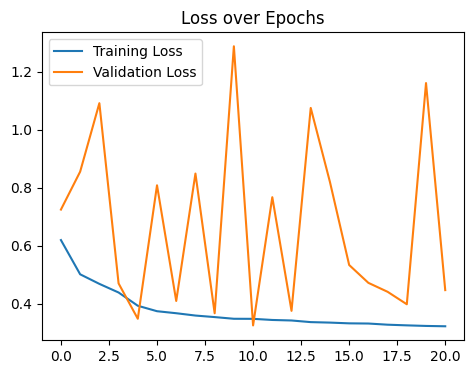

In [20]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')

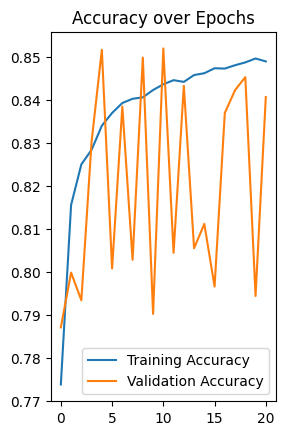

In [21]:
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.show()

816/816 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step


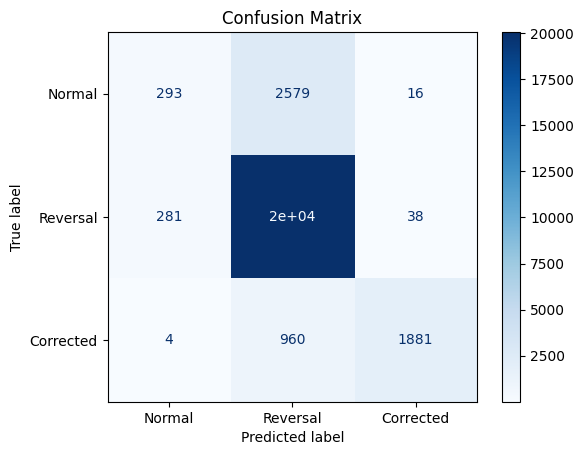

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict the labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Reversal', 'Corrected'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


816/816 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8526 - loss: 0.3156


Test accuracy: 0.8515
Test loss: 0.3234


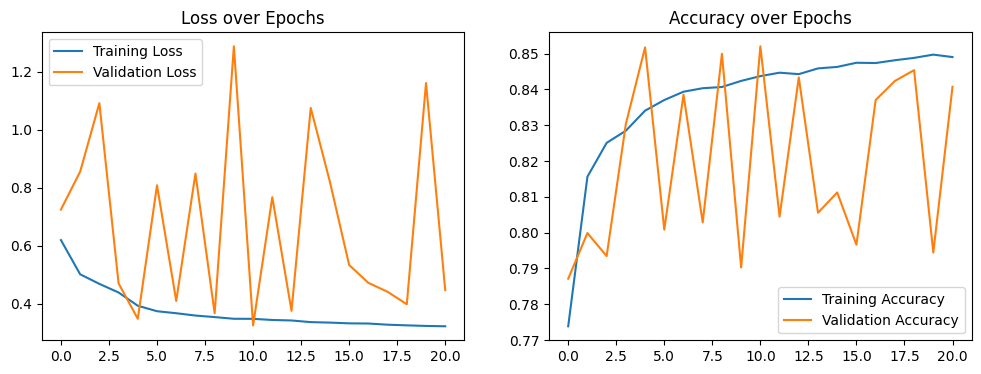

816/816 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step


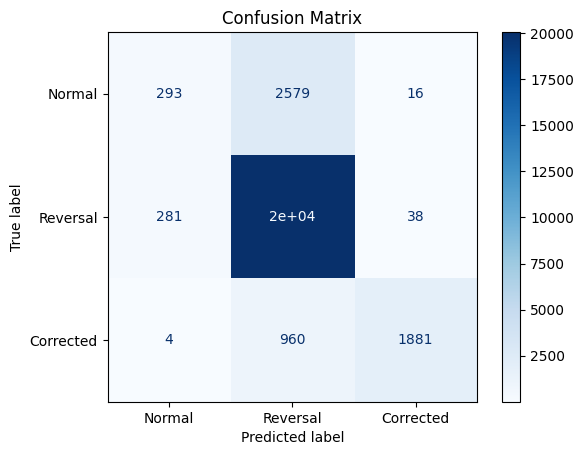

In [23]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy:.4f}')
print(f'Test loss: {test_loss:.4f}')

# Save the model
model.save('handwriting_classification_model.h5')

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.show()

# Confusion Matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict the labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Reversal', 'Corrected'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


816/816 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step


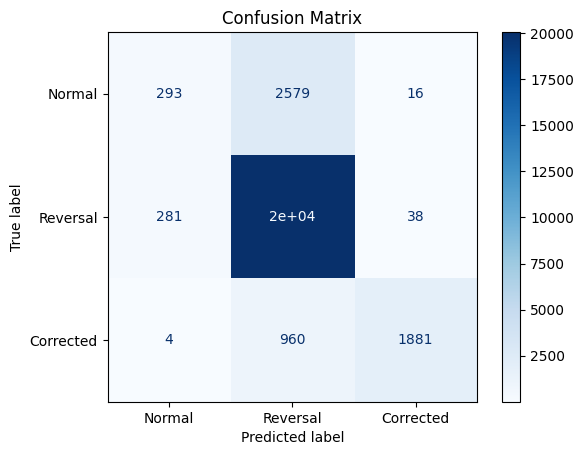

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict the labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Reversal', 'Corrected'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')

# Save the confusion matrix as an image file
plt.savefig('confusion_matrix.png')  # You can change the file name and format as needed

# Show the plot
plt.show()
